# The Issue Description

Consider we have a taxi service. The important part of our business is a supply/demand balance. We can’t control demand but we can shift some supply to necessary hours to cover more demand during peaks. Here we have samples of supply and demand data over a few weeks in a single city:
- Supply dataset shows aggregated driver activity in a city for a given period.
- Demand dataset shows how many people saw a car in the app when setting the pickup marker on the map.

We're going to evaluate the current balance and estimate the additional number for resources to reach currently uncovered demand.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 15,6
from datetime import datetime 
import typing as tp

### Drivers (supply) 

Supply dataset shows aggregated driver activity in a city for a given period.

Details:
- Date – date + hour for which the row of data is presented
- Active drivers – number of active drivers (any level of activity) available during time period
- Online (h) – total supply hours that were available during time period
- Has booking (h) – total hours during which drivers had a client booking (any state)
- Waiting for booking (h) – total hours which drivers spent waiting for booking
- Rides per online hour – aka RPH – avg. finished trips per online hour during period
- Finished Rides – number of finished trips during period

If time period has 0 values in all columns, it would be skipped (no row)


In [2]:
df_drivers = pd.read_excel("Drivers.xlsx")

df_drivers = df_drivers.rename(
    columns = {
    "Date": "date"
    , "Active drivers": "active_drivers"
    , "Online (h)": "online"
    , "Has booking (h)": "has_booking"
    , "Waiting for booking (h)": "waiting_for_booking"
    , "Rides per online hour": "rides_per_online_hour"
    , "Finished Rides": "finished_rides"    
    }
)

df_drivers.head()

,date,active_drivers,online,has_booking,waiting_for_booking,rides_per_online_hour,finished_rides
0,2016-12-18 23,52,18,6,11,0.67,12.0
1,2016-12-18 22,59,20,11,9,1.40,28.0
2,2016-12-18 21,72,25,7,18,0.64,16.0
3,2016-12-18 20,86,29,7,23,0.52,15.0
4,2016-12-18 19,82,31,14,17,1.16,36.0


### Customers (demand) 

Demand dataset shows how many people saw a car in the app when setting the pickup marker on the map. 

Details:
- Date – date + hour for which the row of data is presented
- People saw 0 cars (unique) – number of users who didn’t not see a car.
- People saw +1 cars (unique) – number of users who saw a car.

If time period has 0 values in all columns, it would be skipped (no row).

In [3]:
df_customers = pd.read_excel("Customers.xlsx")

df_customers = df_customers.rename(
    columns = {
    "Date": "date"
    , "People saw 0 cars (unique)": "people_saw_0_cars"
    , "People saw +1 cars (unique)": "people_saw_cars"
    }
)

df_customers.head()

,date,people_saw_0_cars,people_saw_cars
0,2016-12-18 23,9,32
1,2016-12-18 22,29,64
2,2016-12-18 21,5,39
3,2016-12-18 20,13,48
4,2016-12-18 19,12,77


# Data Preparation

### Validation point 

Due to some timeperiods are skipped in both dataset we need to make a full join ot them - an outer join on generated calendar.
Firstly let's check do we have any duplication cases.

In [4]:
df_drivers.groupby("date").count().reset_index().sort_values(by = "active_drivers", ascending = False )[:1]

,date,active_drivers,online,has_booking,waiting_for_booking,rides_per_online_hour,finished_rides
0,2016-11-14 00,1,1,1,1,1,1


In [5]:
df_customers.groupby("date").count().reset_index().sort_values(by = "people_saw_0_cars", ascending = False )[:1]

,date,people_saw_0_cars,people_saw_cars
0,2016-11-14 00,1,1


### Calendar 

As the next step we need to create a datetime range due to some of hours could be skipped in primary datasets.

In [6]:
#max and min date values from both datasets
start_point = min([df_drivers["date"].min(), df_customers["date"].min()])
end_point = max([df_drivers["date"].max(), df_customers["date"].max()])

#create range of dates
date_list = pd.date_range(start = start_point, end = end_point, freq = "h").tolist()

#make from datetime the format of date at primary dataset 
date_df = pd.DataFrame({'datetime': date_list})
date_df["datetime"] = date_df["datetime"].astype('str')
date_df["date"] = ""

for i in range(date_df.shape[0]):
    split_list = date_df.at[i, "datetime"].split(":")
    date_df.at[i, "date"] = split_list[0]

date_df.head()

,datetime,date
0,2016-11-14 00:00:00,2016-11-14 00
1,2016-11-14 01:00:00,2016-11-14 01
2,2016-11-14 02:00:00,2016-11-14 02
3,2016-11-14 03:00:00,2016-11-14 03
4,2016-11-14 04:00:00,2016-11-14 04


### Dataset 

And finally we're going to make several joins. Let's add some attributes and also consider that supply data should has prefix "s_", as well as demand data - "d_".

In [7]:
#outer join of both datasets to calendar 
df = pd.merge( pd.merge(date_df, df_customers, on = "date", how = "left"), df_drivers, on = "date", how = "left")

#create numbers and names of days
for i in range(df.shape[0]):
    split_list = df.at[i, "date"].split(" ")
    df.at[i, "hour"] = split_list[1]
    df.at[i, "dt"] = split_list[0]
    
df["dt"] = df["dt"].astype('datetime64')
df["day"] = df["dt"].dt.day_name()

dict_days = {"Monday": 1, "Tuesday": 2, "Wednesday": 3, "Thursday": 4, "Friday": 5, "Saturday": 6, "Sunday": 7}
for i in range(df.shape[0]):
    df.at[i, "day_number"] = dict_days[df.at[i, "day"]]
    
#finally rename and prop several columns
df = df.rename(columns = {
    #demand data
    "people_saw_0_cars": "d_people_saw_0_cars"
    , "people_saw_cars": "d_people_saw_cars"
    #supply data
    , "active_drivers": "s_active_drivers"
    , "online": "s_online"
    , "has_booking": "s_has_booking"
    , "waiting_for_booking": "s_waiting_for_booking"
    , "rides_per_online_hour": "s_rides_per_online_hour"
    , "finished_rides": "s_finished_rides"
})

df = df.drop(columns = ["datetime", "date"])
df.head()

,d_people_saw_0_cars,d_people_saw_cars,s_active_drivers,s_online,s_has_booking,s_waiting_for_booking,s_rides_per_online_hour,s_finished_rides,hour,dt,day,day_number
0,9.0,15.0,38,14,3,11,0.43,6.0,00,2016-11-14,Monday,1.0
1,8.0,8.0,29,9,1,8,0.22,2.0,01,2016-11-14,Monday,1.0
2,3.0,6.0,21,7,0,7,0.14,1.0,02,2016-11-14,Monday,1.0
3,1.0,2.0,18,7,0,7,0.00,NaN,03,2016-11-14,Monday,1.0
4,4.0,4.0,15,6,0,6,0.00,NaN,04,2016-11-14,Monday,1.0


# The Solution

We are going to evaluate supply and demand correlation, in this case we need to create some common metrics for it. For example, I don't want to calculate some ratios like the number of customers who saw at least one available car divided by all customers - it doesn't have any sence due to its different number during the entire day as well as during the entire week. 

Consider that **demand** is a time metric: the number of customers at analyzed time multipled on the average length of the ride - it could be evaluated from supply dataset as "s_online" / "s_finished_rides" per each hour: overall time where all drivers were booked divided by completed rides. That's total time that our customers request for rides. It could be easily convetred to financial metric in some further evaluations. Consider that one customer make only one ride per one hour.

Consider the same regarding **supply**: that's the total time that we propose for our customers - online time and its partition to cases when drivers were booked and when they were waiting for booking.

As it was mentioned above some data could be skipped so in these cases I'm going to replace it by average values of the same hour at this day and the average of the same hour of all days.

In case if we have a lot of drivers but they still are unchosen by customers it means we need to do something with their distribution or with conditions for customers. I guess, it's not a case of supply lack. It seems to be reasonable to divide demand issue on two separate parts: 
- **"Unfound Demand"**: cases when customers didn't find any car; 
- **"Unchosen Demand"**: cases when customers saw at least one car but didn't convert to finished ride.

## Dataset 

In [8]:
#data for replacing null values in primary dataset for demand calculation

#replacement one - average values per hour and day
avg_hour_day = df.groupby(["day_number", "hour"]).mean()[["s_finished_rides", "s_has_booking"]].reset_index()

#replacement two - average values per hour
avg_hour = df.groupby(["hour"]).mean()[["s_finished_rides", "s_has_booking"]].reset_index()

#left join for replacement like in sql's coalesce
df_calc = pd.merge(pd.merge(df, avg_hour_day, how = "left", on = ["day_number", "hour"]), avg_hour, how = "left", on = "hour")

df_calc = df_calc.rename(columns = {
    "s_finished_rides": "s_finished_rides_hour"
    , "s_has_booking": "s_has_booking_hour"    
    , "s_finished_rides_y": "s_finished_rides_day"    
    , "s_has_booking_y": "s_has_booking_day"    
    , "s_finished_rides_x": "s_finished_rides"    
    , "s_has_booking_x": "s_has_booking"    
})


def demand_values(i: int, df: tp.Any) -> tp.Any:
    """
    Demand calculating for analogue of sql's coalesce
    """
    people_saw_0_cars = df.at[i, "d_people_saw_0_cars"]
    people_saw_cars = df.at[i, "d_people_saw_cars"]

    finished_rides = df.at[i, "s_finished_rides"]
    has_booking = df.at[i, "s_has_booking"]
    
    finished_rides_rep1 = df.at[i, "s_finished_rides_day"]
    has_booking_rep1 = df.at[i, "s_has_booking_day"]
    
    finished_rides_rep2 = df.at[i, "s_finished_rides_hour"]
    has_booking_rep2 = df.at[i, "s_has_booking_hour"]
    
    hb_value = 0.0
    fr_value = 0.0
    
    if finished_rides == finished_rides and has_booking != 0:
        hb_value = has_booking
        fr_value = finished_rides
    elif (finished_rides != finished_rides or has_booking == 0) and finished_rides_rep1 == finished_rides_rep1:
        hb_value = has_booking_rep1
        fr_value = finished_rides_rep1
    elif (finished_rides != finished_rides or has_booking == 0) and finished_rides_rep1 != finished_rides_rep1:
        hb_value = has_booking_rep2
        fr_value = finished_rides_rep2
        
    total = (people_saw_0_cars + people_saw_cars) * (hb_value / fr_value)
    unfound = people_saw_0_cars * (hb_value / fr_value)
    unchosen = (people_saw_cars - fr_value) * (hb_value / fr_value)
        
    return total, unfound, unchosen

for i in range(df_calc.shape[0]):
    df_calc.at[i, "total_demand"] = demand_values(i, df_calc)[0]
    df_calc.at[i, "unfound_demand"] = demand_values(i, df_calc)[1]
    df_calc.at[i, "unchosen_demand"] = demand_values(i, df_calc)[2]
        
df_calc.head()

,d_people_saw_0_cars,d_people_saw_cars,s_active_drivers,s_online,s_has_booking,s_waiting_for_booking,s_rides_per_online_hour,s_finished_rides,hour,dt,day,day_number,s_finished_rides_day,s_has_booking_day,s_finished_rides_hour,s_has_booking_hour,total_demand,unfound_demand,unchosen_demand
0,9.0,15.0,38,14,3,11,0.43,6.0,00,2016-11-14,Monday,1.0,7.0,2.6,19.685714,7.714286,12.000000,4.500000,4.500000
1,8.0,8.0,29,9,1,8,0.22,2.0,01,2016-11-14,Monday,1.0,4.0,1.6,13.264706,5.200000,8.000000,4.000000,3.000000
2,3.0,6.0,21,7,0,7,0.14,1.0,02,2016-11-14,Monday,1.0,2.4,0.6,10.125000,3.685714,2.250000,0.750000,0.900000
3,1.0,2.0,18,7,0,7,0.00,NaN,03,2016-11-14,Monday,1.0,1.0,0.2,10.035714,3.114286,0.600000,0.200000,0.200000
4,4.0,4.0,15,6,0,6,0.00,NaN,04,2016-11-14,Monday,1.0,3.0,0.2,10.000000,2.657143,0.533333,0.266667,0.066667


And finally let's change a bit this dataset for further analysis.

In [9]:
dataset = df_calc[["dt", "day", "day_number", "hour", "total_demand", "unfound_demand", "unchosen_demand", "s_active_drivers", "s_online", "s_has_booking", "s_waiting_for_booking"]]
dataset = dataset.rename(columns = {
    "s_online": "total_supply"
    , "s_has_booking": "applied_supply"    
    , "s_waiting_for_booking": "wasted_supply"   
    , "s_active_drivers": "active_drivers"
})

dataset["total_demand"] = round(dataset["total_demand"], 2)
dataset["unfound_demand"] = round(dataset["unfound_demand"], 2)
dataset["unchosen_demand"] = round(dataset["unchosen_demand"], 2)

dataset.head()

,dt,day,day_number,hour,total_demand,unfound_demand,unchosen_demand,active_drivers,total_supply,applied_supply,wasted_supply
0,2016-11-14,Monday,1.0,00,12.00,4.50,4.50,38,14,3,11
1,2016-11-14,Monday,1.0,01,8.00,4.00,3.00,29,9,1,8
2,2016-11-14,Monday,1.0,02,2.25,0.75,0.90,21,7,0,7
3,2016-11-14,Monday,1.0,03,0.60,0.20,0.20,18,7,0,7
4,2016-11-14,Monday,1.0,04,0.53,0.27,0.07,15,6,0,6


Aggregate this data per each hour of each day.

In [10]:
dataset_agg = dataset.groupby(["day", "day_number", "hour"]).mean()[["total_demand", "unfound_demand", "unchosen_demand", "total_supply", "applied_supply", "wasted_supply", "active_drivers"]].sort_values(by = ["day_number", "hour"]).reset_index()
dataset_agg.head()

,day,day_number,hour,total_demand,unfound_demand,unchosen_demand,total_supply,applied_supply,wasted_supply,active_drivers
0,Monday,1.0,00,11.716,3.142,5.974,14.6,2.6,11.8,40.0
1,Monday,1.0,01,8.030,2.576,3.734,10.4,1.6,9.2,29.6
2,Monday,1.0,02,2.984,0.868,1.276,7.6,0.6,6.8,20.4
3,Monday,1.0,03,2.840,1.560,0.920,5.4,0.2,5.2,14.8
4,Monday,1.0,04,0.852,0.416,0.082,4.8,0.2,4.6,12.4


## Total Demand

Let's see days and timeslots which are more preferable for ride among our customers.

Text(0, 0.5, 'Demand in hours')

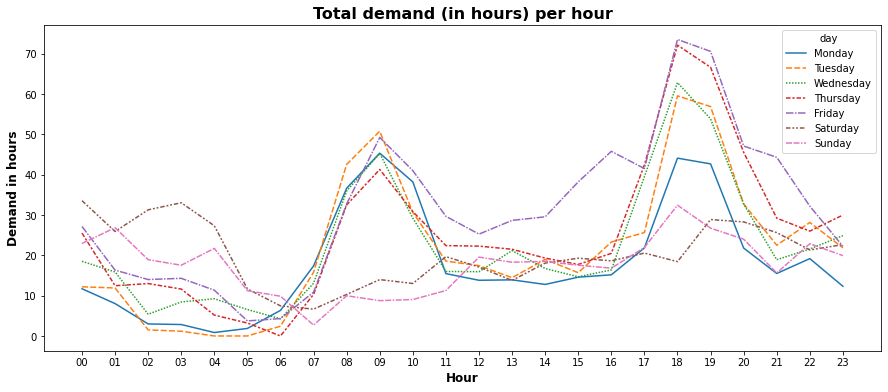

In [11]:
total_demand = dataset_agg.copy()
total_demand = total_demand[["day", "day_number", "hour", "total_demand", "total_supply"]]

#chart parameters
dt_lines = sns.lineplot(
    data = total_demand
    , x = "hour"
    , y = "total_demand"
    , hue = "day"
    , style = "day"
)

dt_lines.set_title("Total demand (in hours) per hour", fontweight ="bold", size = 16)
dt_lines.set_xlabel("Hour", fontweight ="bold", size = 12)
dt_lines.set_ylabel("Demand in hours", fontweight ="bold", size = 12)

No surpise that weekday's mornings and evenings seem to be the most likely for rides.

The same at the heatmap.

Text(114.0, 0.5, 'Day number from Monday')

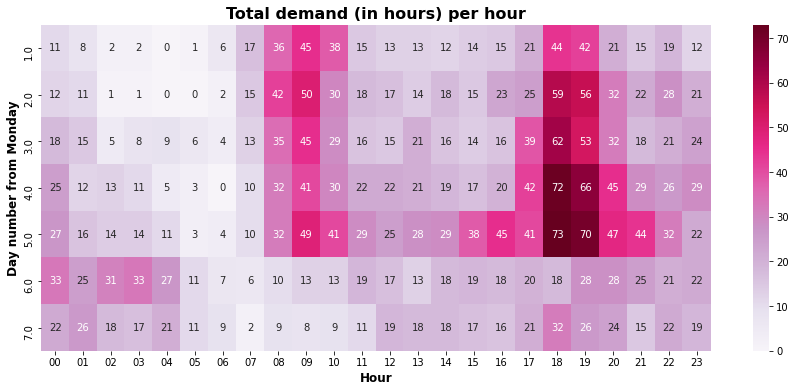

In [12]:
demand_df = total_demand.copy()
demand_df["total_demand"] = demand_df["total_demand"].astype('int64')
demand_df = demand_df.pivot("day_number", "hour", "total_demand")

#chart parameters
dt_heatmap = sns.heatmap(
    demand_df
    , annot = True
    , fmt = "d"
    , cmap="PuRd"
)

dt_heatmap.set_title("Total demand (in hours) per hour", fontweight ="bold", size = 16)
dt_heatmap.set_xlabel("Hour", fontweight ="bold", size = 12)
dt_heatmap.set_ylabel("Day number from Monday", fontweight ="bold", size = 12)

## Supply-Demand balance 

Let's see the same day by day and mark timedelta from 7 am till 10 am as well as from 5 pm till 8 pm where demand is higher.

In [13]:
df_demand = dataset_agg[["day", "hour", "total_demand"]]
df_demand["type"] = "total_demand"
df_demand = df_demand.rename(columns = {"total_demand":"value"})

df_supply = dataset_agg[["day", "hour", "total_supply"]]
df_supply["type"] = "total_supply"
df_supply = df_supply.rename(columns = {"total_supply":"value"})

fin = pd.concat([df_supply, df_demand])

#avg values per day
fin_avg_days = fin.groupby(["type", "hour"]).mean()["value"].reset_index()

Firstly the average values for all days.

Text(0, 0.5, 'Demand in hours')

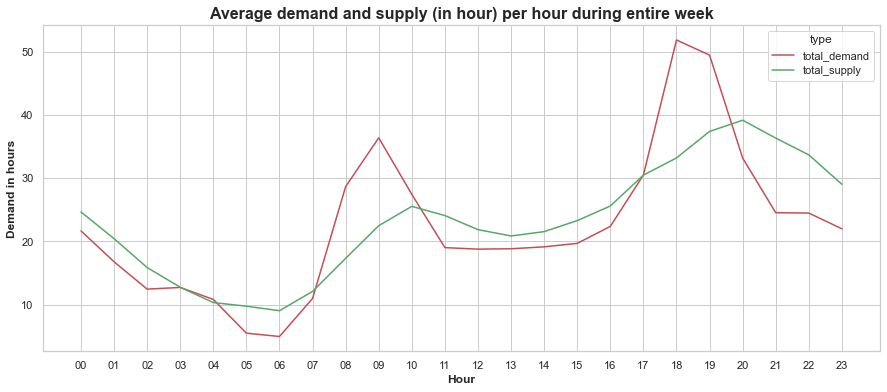

In [14]:
#chart parameters
sns.set_theme(style="whitegrid")

line_avg = sns.lineplot(
        x = "hour"
        , y = "value"
        , data = fin_avg_days
        , hue = "type"
        , palette = ['r', 'g']
)

line_avg.set_title("Average demand and supply (in hour) per hour during entire week", fontweight ="bold", size = 16)
line_avg.set_xlabel("Hour", fontweight ="bold", size = 12)
line_avg.set_ylabel("Demand in hours", fontweight ="bold", size = 12)

And then for each day separately.

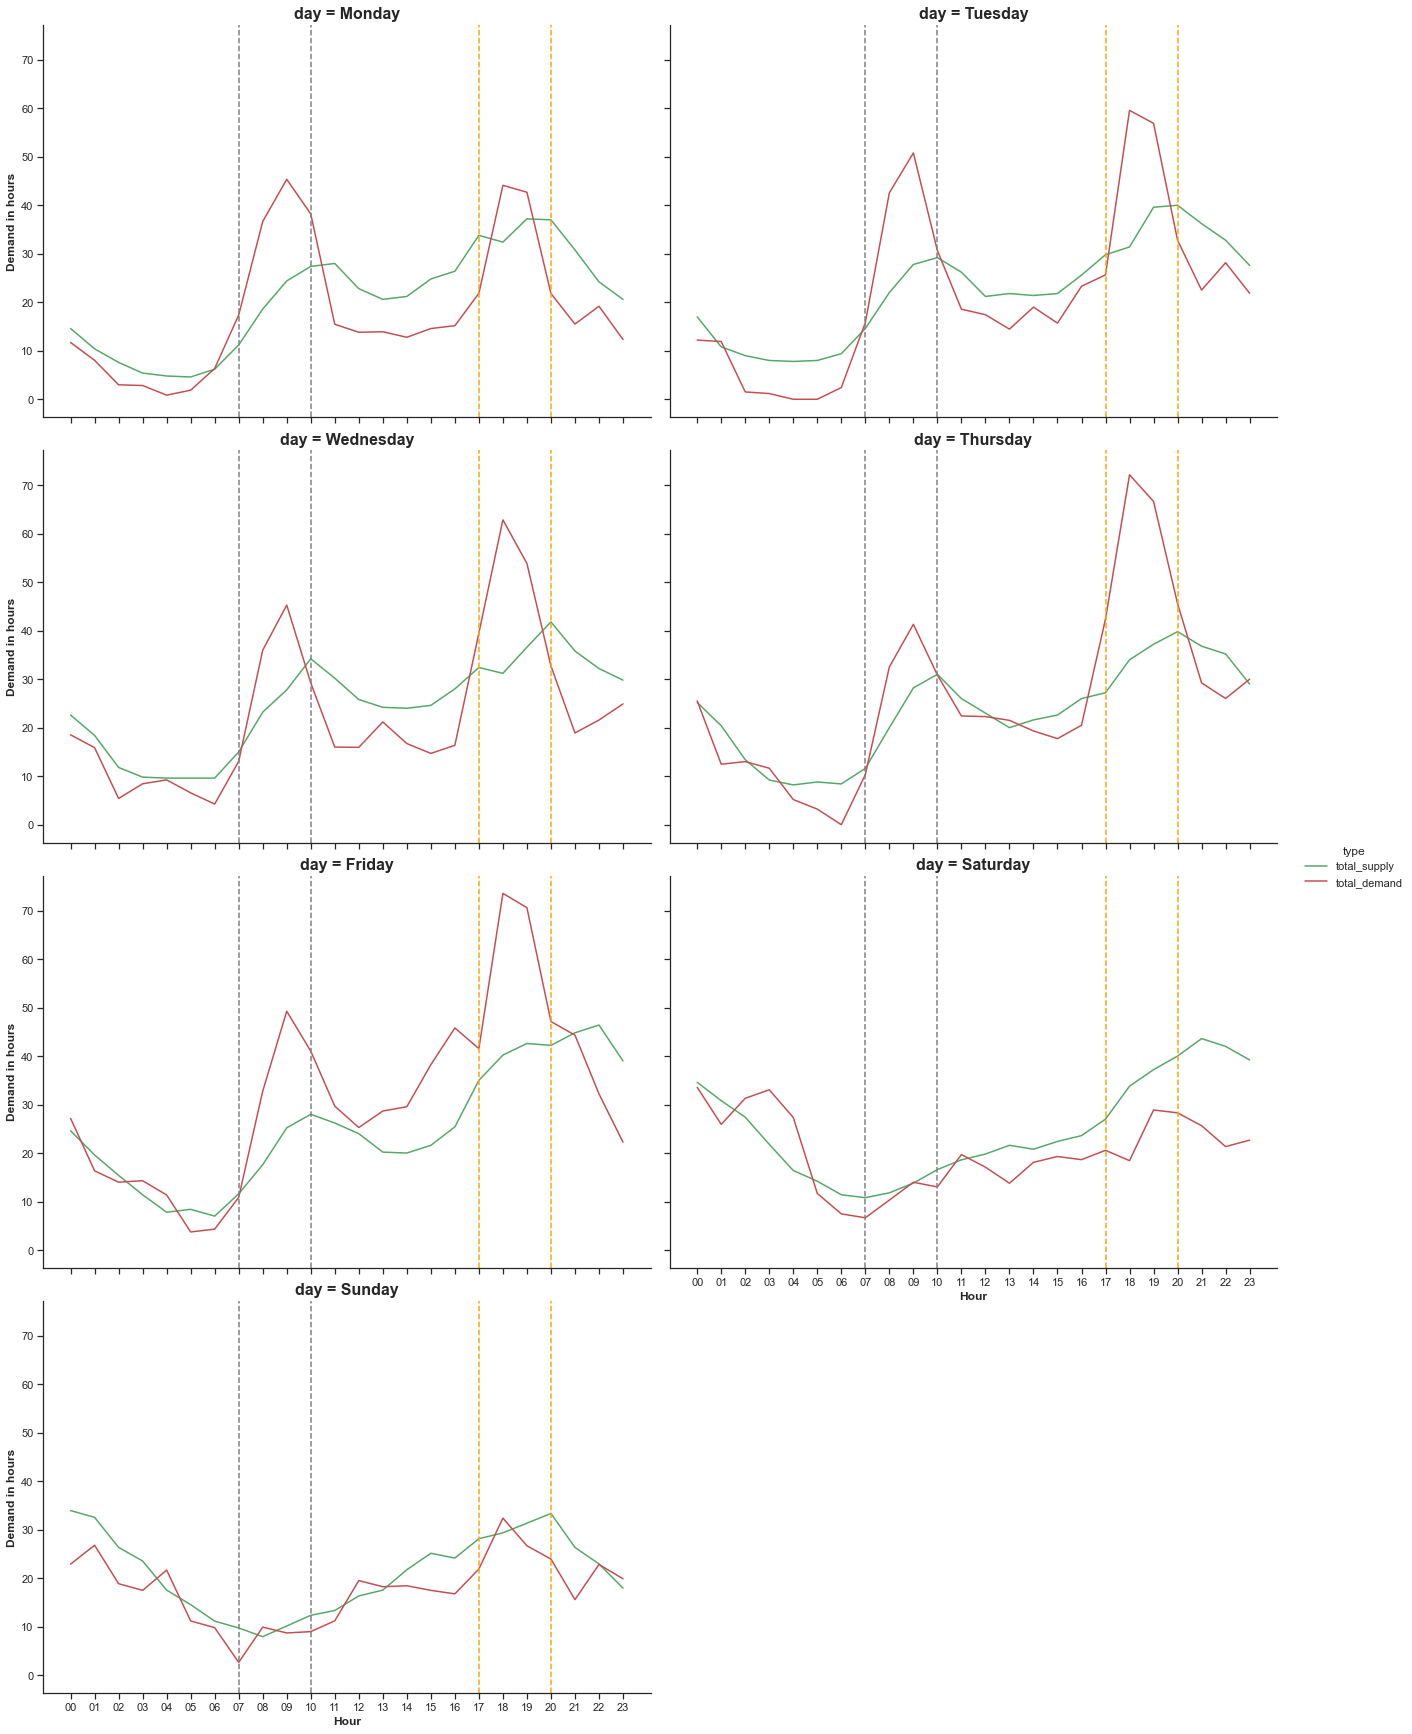

In [15]:
sns.set_theme(style="ticks")
line_per_day = sns.relplot(
        x = "hour"
        , y = "value"
        , data = fin
        , hue = "type"
        , col = "day"
        , col_wrap = 2
        , kind = "line"
        , palette = ['g', 'r']
        , height = 6
        , aspect = 1.5
        , facet_kws=dict(legend_out=True)
    )
        
(
    line_per_day.map(plt.axvline, x = 7, lw = 1.5, color = 'gray', linestyle = '--', label = '7 a.m.')
     .map(plt.axvline, x = 10, lw = 1.5, color = 'gray', linestyle = '--')
     .map(plt.axvline, x = 17, lw = 1.5, color = 'orange', linestyle = '--')
     .map(plt.axvline, x = 20, lw = 1.5, color = 'orange', linestyle = '--') 
     .set_titles(loc = 'center', size = 16, fontweight ="bold")
     .set_xlabels("Hour", fontweight ="bold", size = 12)
     .set_ylabels("Demand in hours", fontweight ="bold", size = 12)
)
    

## Results and Conclusions 

So now we need to evaluate how much supply in hours as well as in drivers we need to attract for a better demand-supply balance. 

As we have mentioned previously not all supply is applied by customers.

Text(0, 0.5, 'Demand-supply in hours')

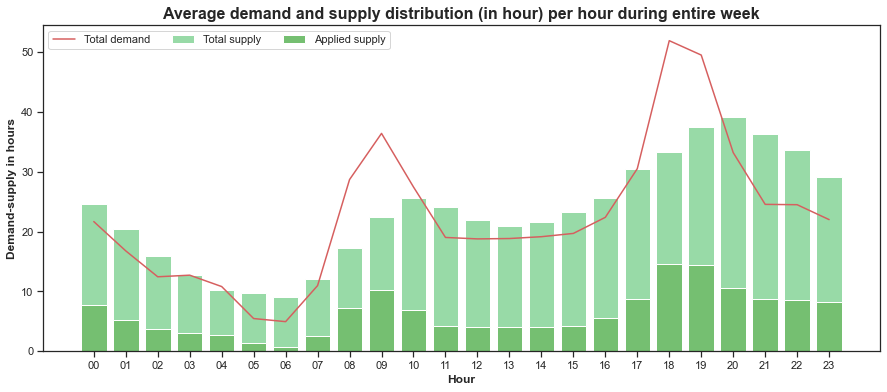

In [16]:
sns.set_color_codes("pastel")
bar_sup = sns.barplot(
    data = dataset_agg
    , x = "hour"
    , y = "total_supply"
    , ci = None
    , palette = ['g']
    , label = "Total supply"
)

sns.set_color_codes("muted")
bar_sup = sns.barplot(
    data = dataset_agg
    , x = "hour"
    , y = "applied_supply"
    , ci = None
    , palette = ['g']
    , label = "Applied supply"
)

f = sns.lineplot(
    data = dataset_agg
    , x = "hour"
    , y = "total_demand"
    , color = 'r'
    , label = "Total demand"
    , ci = None
)

bar_sup.legend(ncol = 3, loc="upper left", frameon=True)
bar_sup.set_title("Average demand and supply distribution (in hour) per hour during entire week", fontweight ="bold", size = 16)
bar_sup.set_xlabel("Hour", fontweight ="bold", size = 12)
bar_sup.set_ylabel("Demand-supply in hours", fontweight ="bold", size = 12)

Text(0, 0.5, 'Supply-demand in hours')

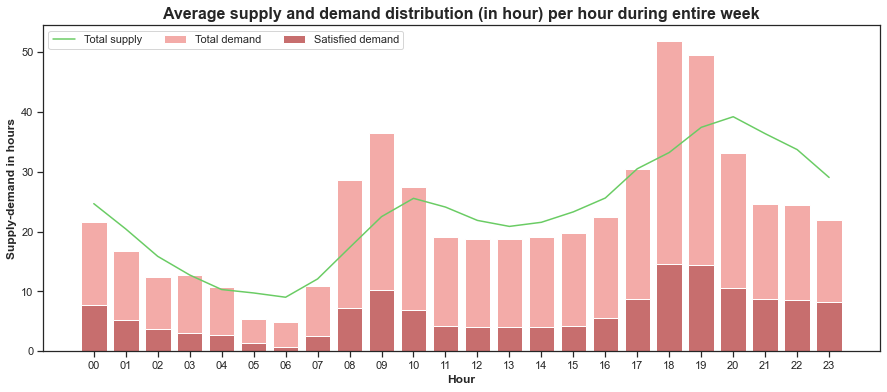

In [17]:
sns.set_color_codes("pastel")
bar_sup = sns.barplot(
    data = dataset_agg
    , x = "hour"
    , y = "total_demand"
    , ci = None
    , palette = ['r']
    , label = "Total demand"
)

sns.set_color_codes("muted")
bar_sup = sns.barplot(
    data = dataset_agg
    , x = "hour"
    , y = "applied_supply"
    , ci = None
    , palette = ['r']
    , label = "Satisfied demand"
)

bar_sup = sns.lineplot(
    data = dataset_agg
    , x = "hour"
    , y = "total_supply"
    , color = 'g'
    , label = "Total supply"
    , ci = None
)

bar_sup.legend(ncol = 3, loc="upper left", frameon=True)
bar_sup.set_title("Average supply and demand distribution (in hour) per hour during entire week", fontweight ="bold", size = 16)
bar_sup.set_xlabel("Hour", fontweight ="bold", size = 12)
bar_sup.set_ylabel("Supply-demand in hours", fontweight ="bold", size = 12)

Unsatisfied demand could be divided by two parts: unfound - when people don't see free drivers at all and unchosen - when they rejected our proposals due to some reasons.

Text(0, 0.5, 'Demand in hours')

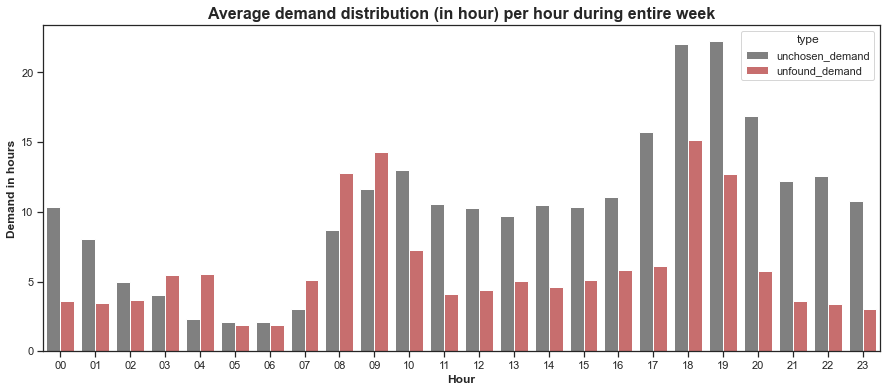

In [18]:
df_demand_unfound = dataset_agg[["day", "hour", "unchosen_demand"]]
df_demand_unfound["type"] = "unchosen_demand"
df_demand_unfound = df_demand_unfound.rename(columns = {"unchosen_demand":"value"})

df_demand_unchosen = dataset_agg[["day", "hour", "unfound_demand"]]
df_demand_unchosen["type"] = "unfound_demand"
df_demand_unchosen = df_demand_unchosen.rename(columns = {"unfound_demand":"value"})
fin_dem_type = pd.concat([df_demand_unfound, df_demand_unchosen])

#avg values per day
fin_avg_days_demand = fin_dem_type.groupby(["type", "hour"]).mean()["value"].reset_index()

bar_dem_sup = sns.barplot(
    data = fin_avg_days_demand
    , x = "hour"
    , y = "value"
    , hue = "type"
    , ci = None
    , palette = ['gray', 'r']
)

bar_dem_sup.set_title("Average demand distribution (in hour) per hour during entire week", fontweight ="bold", size = 16)
bar_dem_sup.set_xlabel("Hour", fontweight ="bold", size = 12)
bar_dem_sup.set_ylabel("Demand in hours", fontweight ="bold", size = 12)

## Required drivers number 

Well, we can notice some correlation between satisfied and unsatisfied demand during the day but the proportion between unchosen and unfound demand seems to be far from constant. I guess we need much data for understanding attributes which influence on customer's decision and further using it in some modelling. 

Regarding current issue consider that the minimum additional supply value for us is the value corresponded to unfound_demand. And the maximum one corresponds to delta between total_demand and applied supply.

Given all proportions between supply and drivers are constant per the same hour and day we can evaluate the required number of drivers who currently provide the total supply.

In [19]:
dataset_final = dataset_agg.copy()

#the minimum value for covering people who saw zero free cars
dataset_final["supply_min"] = dataset_final["unfound_demand"]
#each driver provides some supply per hour
dataset_final["drivers_min"] = (dataset_final["active_drivers"] / dataset_final["total_supply"]) * dataset_final["supply_min"] 

#the same for all previously uncovered demand
dataset_final["supply_max"] = dataset_final["total_demand"] - dataset_final["applied_supply"]
dataset_final["drivers_max"] = (dataset_final["active_drivers"] / dataset_final["total_supply"]) * dataset_final["supply_max"] 

dataset_final = dataset_final[["day", "day_number", "hour", "supply_min", "drivers_min", "supply_max", "drivers_max", "active_drivers"]]
dataset_final["drivers_min"] = round(dataset_final["drivers_min"])
dataset_final["drivers_max"] = round(dataset_final["drivers_max"])
dataset_final["active_drivers"] = round(dataset_final["active_drivers"])

dataset_final.head()

,day,day_number,hour,supply_min,drivers_min,supply_max,drivers_max,active_drivers
0,Monday,1.0,00,3.142,9.0,9.116,25.0,40.0
1,Monday,1.0,01,2.576,7.0,6.430,18.0,30.0
2,Monday,1.0,02,0.868,2.0,2.384,6.0,20.0
3,Monday,1.0,03,1.560,4.0,2.640,7.0,15.0
4,Monday,1.0,04,0.416,1.0,0.652,2.0,12.0


The example for one day.

Text(0, 0.5, 'Drivers')

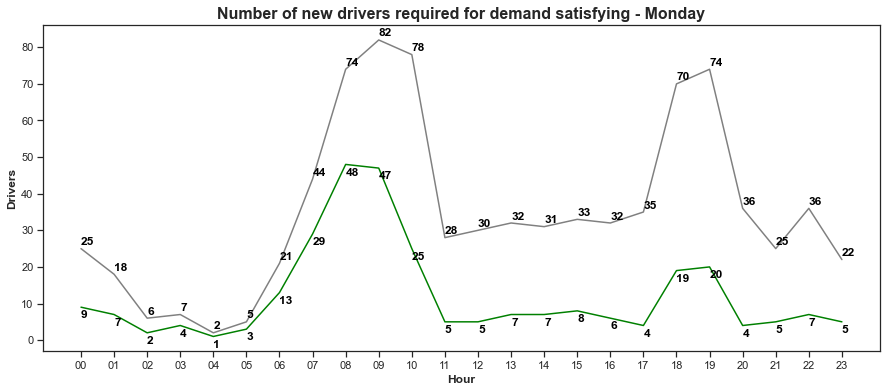

In [20]:
dataset_final_mon = dataset_final.query("day == 'Monday'")

sns.set_theme(style="ticks")

fin_pic = sns.lineplot(
    x = "hour"
    , y = "drivers_min"
    , data = dataset_final_mon
    , ci = None
    , color = "green"
)

for x, y in zip(dataset_final_mon["hour"], dataset_final_mon["drivers_min"]):
 #the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(
     x = x 
     , y = y - 3 
     , s = '{:.0f}'.format(y)
     , color = 'black'
     , fontweight ="bold"
)

fin_pic = sns.lineplot(
    x = "hour"
    , y = "drivers_max"
    , data = dataset_final_mon
    , ci = None
    , color = "gray"
)
    
for x, y in zip(dataset_final_mon["hour"], dataset_final_mon["drivers_max"]):
 # the position of the data label relative to the data point can be adjusted by adding/subtracting a value from the x &/ y coordinates
    plt.text(
     x = x 
     , y = y + 1 
     , s = '{:.0f}'.format(y)
     , color = 'black'
     , fontweight ="bold"
) 

fin_pic.set_title("Number of new drivers required for demand satisfying - Monday", fontweight ="bold", size = 16)
fin_pic.set_xlabel("Hour", fontweight ="bold", size = 12)
fin_pic.set_ylabel("Drivers", fontweight ="bold", size = 12)

Well, now we're able to evaluate the number of drivers that we need to attract for covering the demand per each hour of each day.

The example above is related to the number of drivers we need to hire additionally. Let's transform it to current values and overall tresholds including current number.

In [21]:
dataset_bars = dataset_final.copy()
dataset_bars["min_treshold"] = dataset_bars["active_drivers"] + dataset_bars["drivers_min"]
dataset_bars["max_treshold"] = dataset_bars["active_drivers"] + dataset_bars["drivers_max"]

dataset_weekend = dataset_bars.query("day in ('Sunday', 'Saturday')")
dataset_weekend = dataset_weekend.groupby(["hour"]).mean()[["active_drivers", "min_treshold", "max_treshold"]].reset_index().sort_values(by = "hour")
dataset_weekend["active_drivers"] = round(dataset_weekend["active_drivers"]).astype('int64')
dataset_weekend["min_treshold"] = round(dataset_weekend["min_treshold"]).astype('int64')
dataset_weekend["max_treshold"] = round(dataset_weekend["max_treshold"]).astype('int64')


dataset_weekday = dataset_bars.query("day not in ('Sunday', 'Saturday')")
dataset_weekday = dataset_weekday.groupby(["hour"]).mean()[["active_drivers", "min_treshold", "max_treshold"]].reset_index().sort_values(by = "hour")
dataset_weekday["active_drivers"] = round(dataset_weekday["active_drivers"]).astype('int64')
dataset_weekday["min_treshold"] = round(dataset_weekday["min_treshold"]).astype('int64')
dataset_weekday["max_treshold"] = round(dataset_weekday["max_treshold"]).astype('int64')

Text(0, 0.5, 'Drivers')

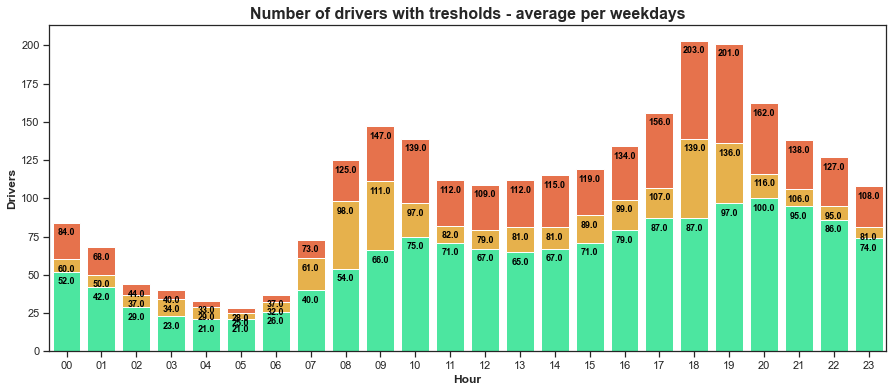

In [22]:
bar_dr = sns.barplot(
    data = dataset_weekday
    , x = "hour"
    , y = "max_treshold"
    , ci = None
    , palette = ['#ff6533']
    , label = "max_treshold"
)
    
bar_dr = sns.barplot(
    data = dataset_weekday
    , x = "hour"
    , y = "min_treshold"
    , ci = None
    , palette = ['#ffb933']
    , label = "min_treshold"
)
    
bar_dr = sns.barplot(
    data = dataset_weekday
    , x = "hour"
    , y = "active_drivers"
    , ci = None
    , palette = ['#33FFA2']
    , label = "active_drivers"
)

for p in bar_dr.patches:
    bar_dr.annotate(
        format(p.get_height())
        , (p.get_x() + p.get_width() / 2., p.get_height())
        , ha='center'
        , va='center'
        , xytext=(0, -10)
        , textcoords='offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 9
    )
    
bar_dr.set_title("Number of drivers with tresholds - average per weekdays", fontweight ="bold", size = 16)
bar_dr.set_xlabel("Hour", fontweight ="bold", size = 12)
bar_dr.set_ylabel("Drivers", fontweight ="bold", size = 12)

Text(0, 0.5, 'Drivers')

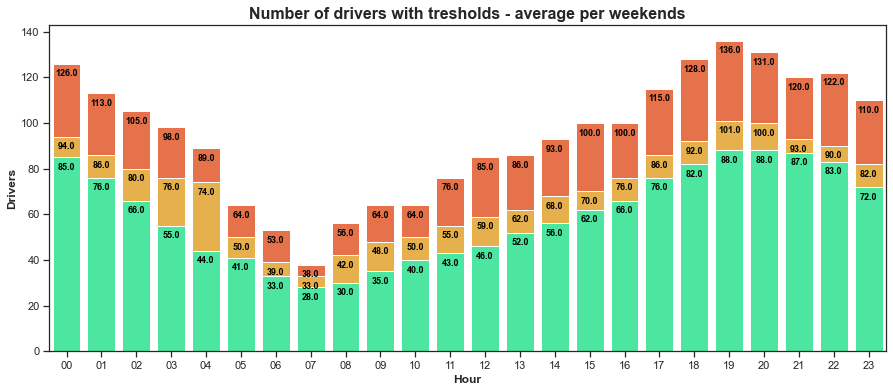

In [23]:
bar_wend = sns.barplot(
    data = dataset_weekend
    , x = "hour"
    , y = "max_treshold"
    , ci = None
    , palette = ['#ff6533']
    , label = "max_treshold"
)
    
bar_wend = sns.barplot(
    data = dataset_weekend
    , x = "hour"
    , y = "min_treshold"
    , ci = None
    , palette = ['#ffb933']
    , label = "min_treshold"
)
    
bar_wend = sns.barplot(
    data = dataset_weekend
    , x = "hour"
    , y = "active_drivers"
    , ci = None
    , palette = ['#33FFA2']
    , label = "active_drivers"
)

for p in bar_wend.patches:
    bar_wend.annotate(
        format(p.get_height())
        , (p.get_x() + p.get_width() / 2., p.get_height())
        , ha='center'
        , va='center'
        , xytext=(0, -10)
        , textcoords='offset points'
        , color = 'black'
        , fontweight ="bold"
        , size = 9
    )
    
bar_wend.set_title("Number of drivers with tresholds - average per weekends", fontweight ="bold", size = 16)
bar_wend.set_xlabel("Hour", fontweight ="bold", size = 12)
bar_wend.set_ylabel("Drivers", fontweight ="bold", size = 12)